In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp
import git

/tmp/ipykernel_542844/3524477660.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"

In [4]:
from collections import defaultdict
import time
import json

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from labellines import labelLine, labelLines


In [6]:
from spectral_connectivity import Multitaper, Connectivity

In [7]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [8]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [9]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [10]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [11]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [12]:
import spikeinterface.full as si

In [13]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Preprocessed LFP 

- Getting the root directory of the Github Repo to base the files off of

In [14]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [15]:
git_root

'/nancy/projects/reward_competition_extention'

- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

In [16]:
lfp_preprocessing_filepath_glob = glob.glob("./proc/*/lfp_preprocessing")

In [17]:
lfp_preprocessing_filepath_glob

['./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged/lfp_preprocessing',
 './proc/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged/lfp_preprocessing']

```
MD EIB: 0(1 on Nancy notebook) Spike Gadgets/Spike Interface: 0
vHPC EIB: 16(17 on Nancy notebook) Spike Gadgets/Spike Interface: 31
BLA EIB: 17(18 on Nancy notebook) Spike Gadgets/Spike Interface: 30
LH EIB: 18(19 on Nancy notebook) Spike Gadgets/Spike Interface: 29
```

In [18]:
brain_region_to_channel = {"mPFC": "21", "MD": "16", "vHPC": "15", "BLA": "14", "LH": "13"}

In [19]:
brain_region_to_channel = {k: v for k, v in sorted(brain_region_to_channel.items(), key=lambda item: item[1])}

In [20]:
brain_region_to_channel.keys()

dict_keys(['LH', 'BLA', 'vHPC', 'MD', 'mPFC'])

In [21]:
brain_region_to_channel.values()

dict_values(['13', '14', '15', '16', '21'])

In [22]:
channel_ids = brain_region_to_channel.values()
time_range=(1000, 1005)
resampled_frequency = 1000

In [23]:
time_halfbandwidth_product=10

### Brain Region to Channel

```
- All Trodes
    - 21, 31, 15, 14, 13
- mPFC:
    - 21 (0 to 31 on Spike interface)
    - 22(1 to 32 on Trodes)
- MD
    - 1 (EIB)
        - Maybe actually 16
    - 31(0 to 31 Spike interface)
        - Maybe actually 16
    - 32(1 to 32 Trodes)
- vHPC
    - 17(EIB)
    - 15(0 to 31 on Spike interface)
    - 16(1 to 32 Trodes)
- BLA
    - 18(BLA)
    - 14(0 to 31 Spike interface)
    - 15(1 to 32 Trodes)
- LH 18
    - 19(EIB)
    - 13(0 to 31 Spike interface)
    - 14(1 to 32 Trodes)
```

In [24]:
resampled_frequency = 1000

In [25]:
recording_intermediate.channel_ids

NameError: name 'recording_intermediate' is not defined

In [27]:
import copy

./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged/lfp_preprocessing
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3418.136s
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3418.136s
ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3418.135s


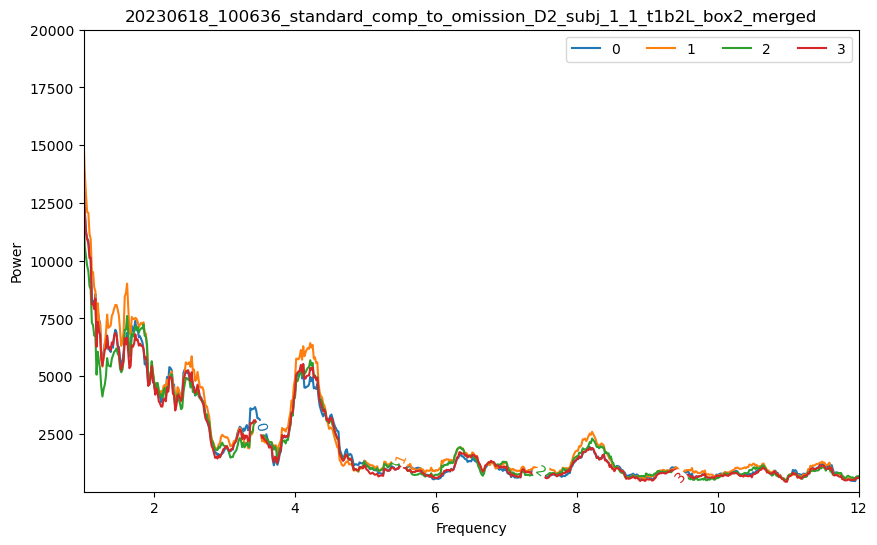

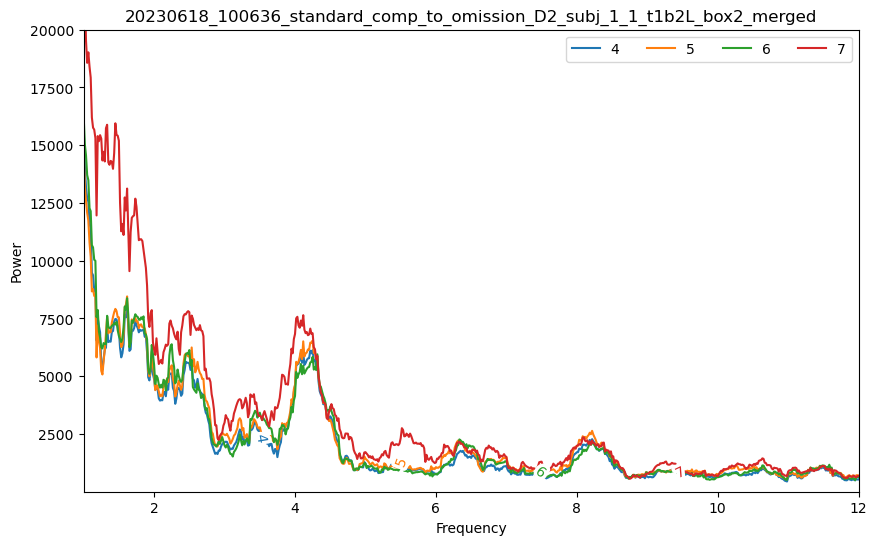

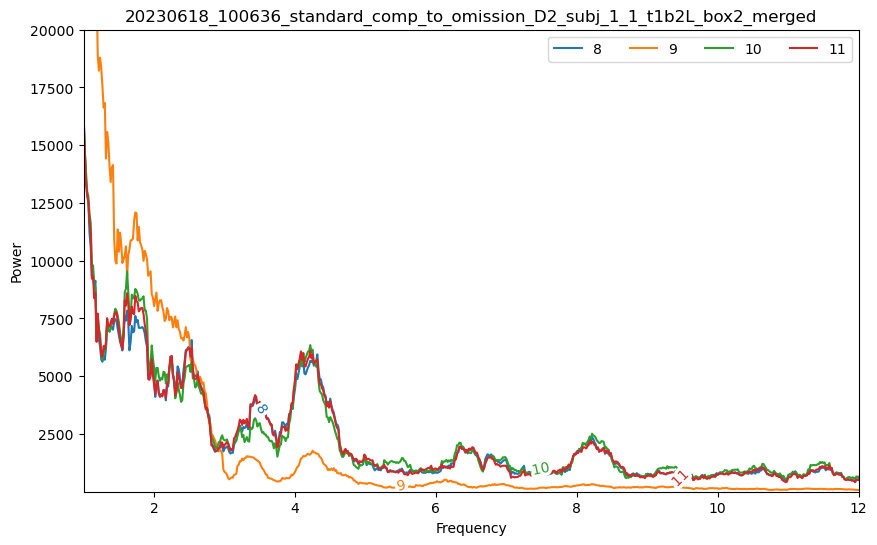

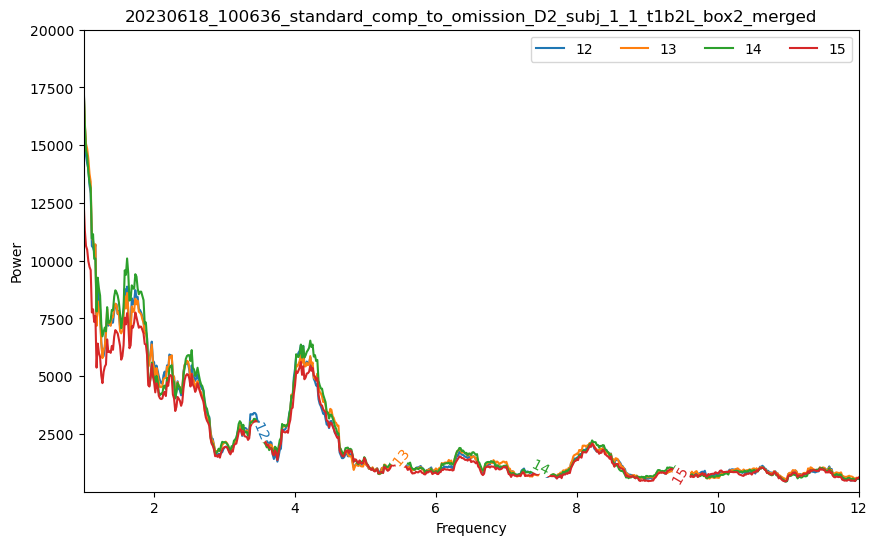

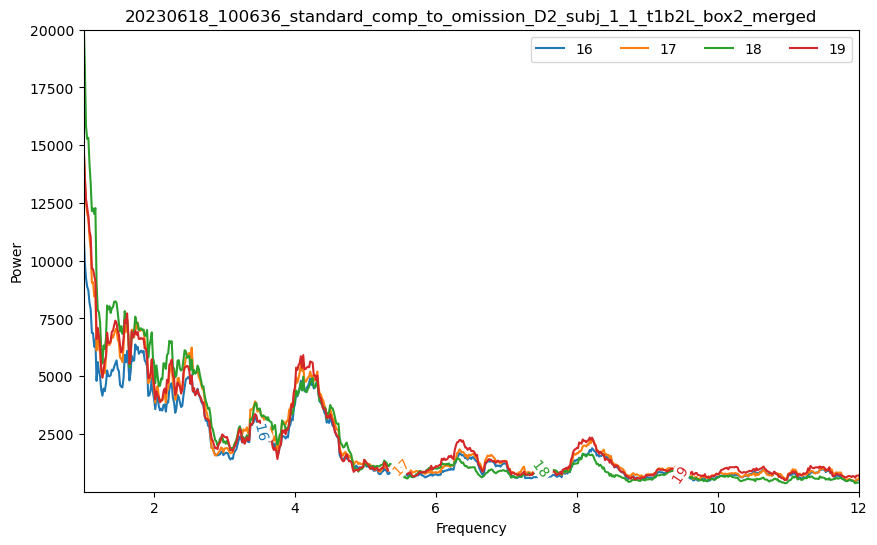

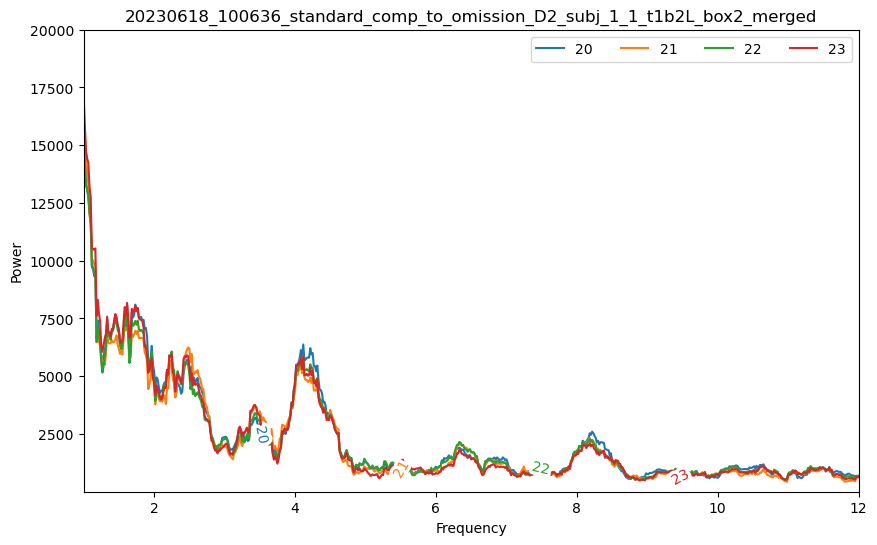

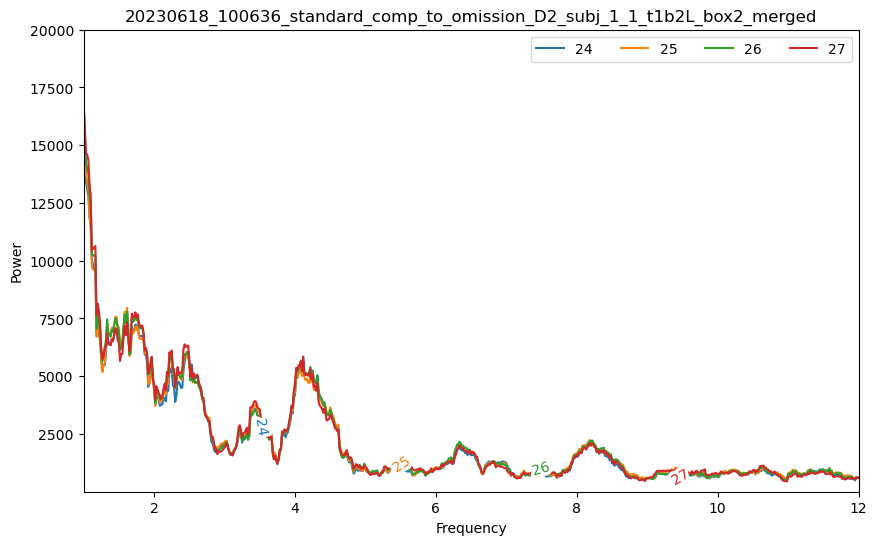

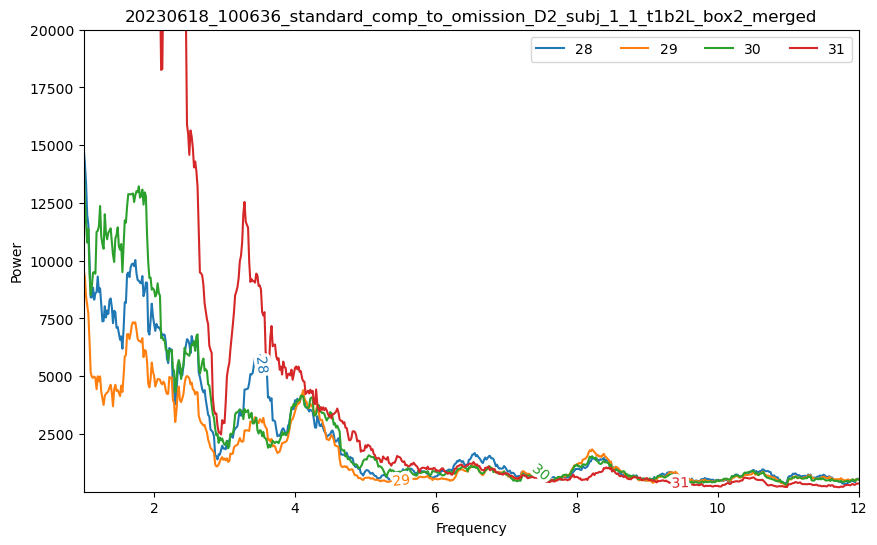

./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged/lfp_preprocessing
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3418.136s
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3418.136s
ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3418.135s


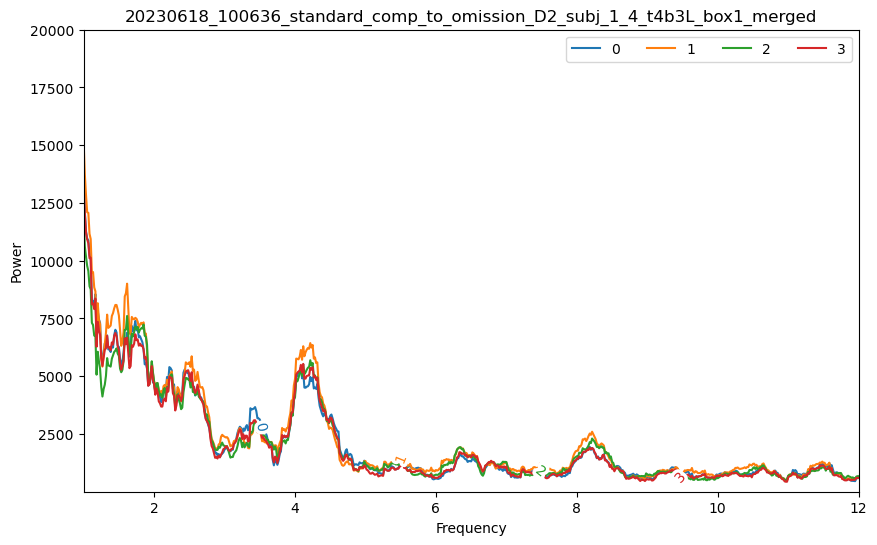

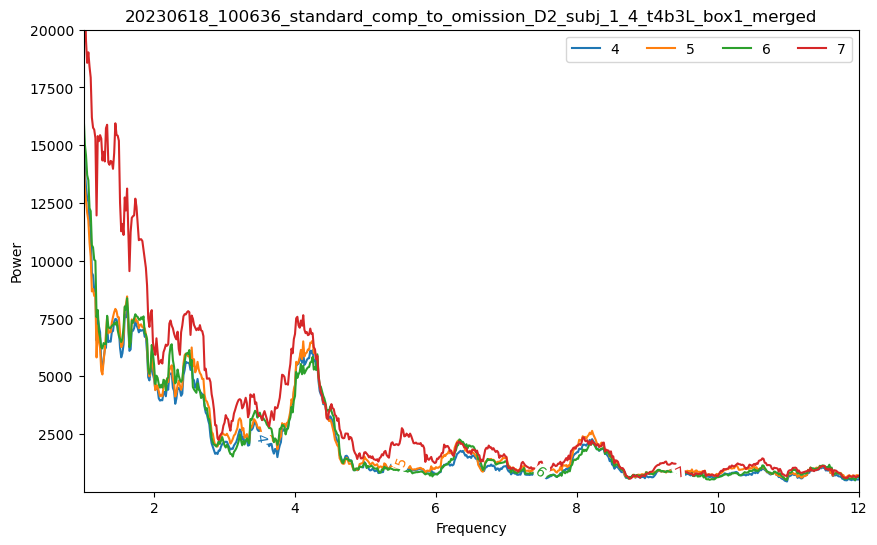

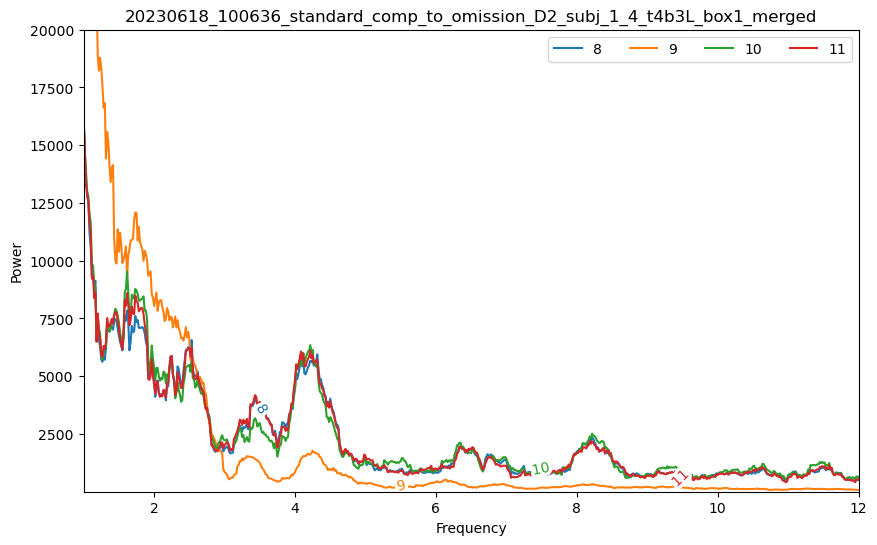

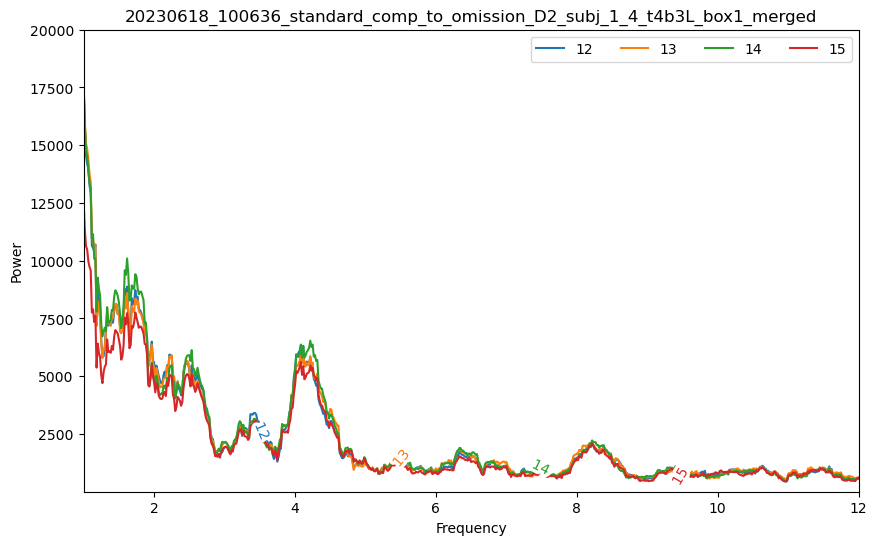

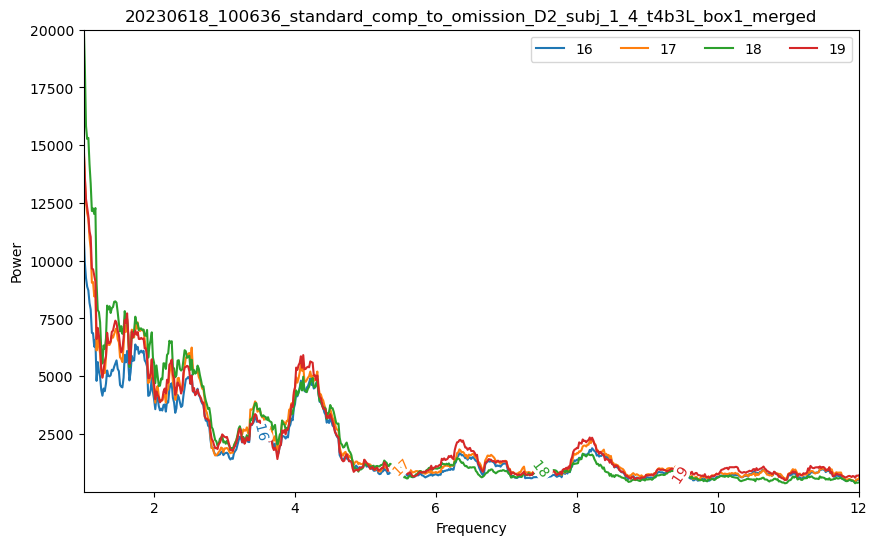

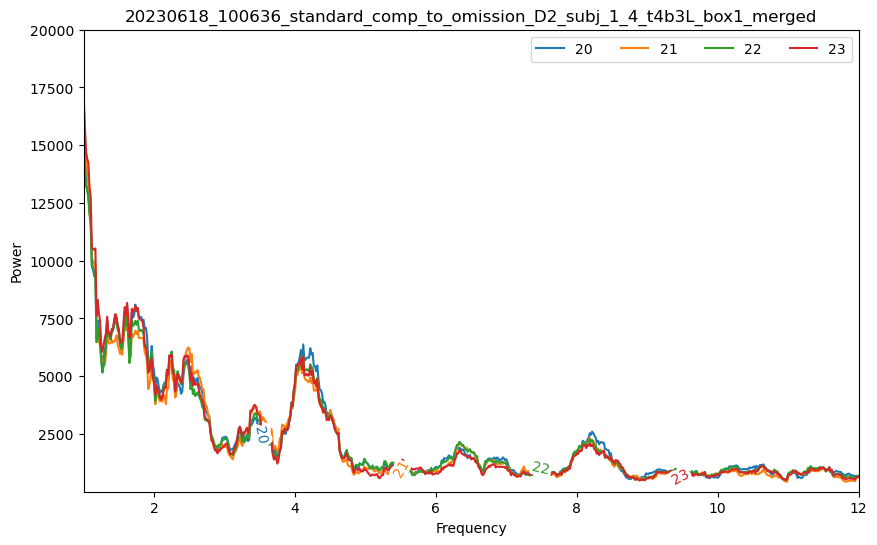

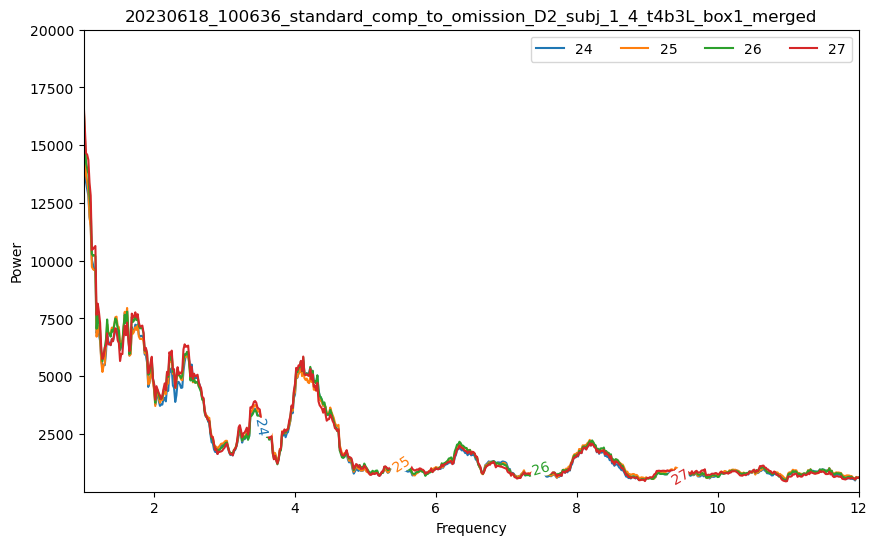

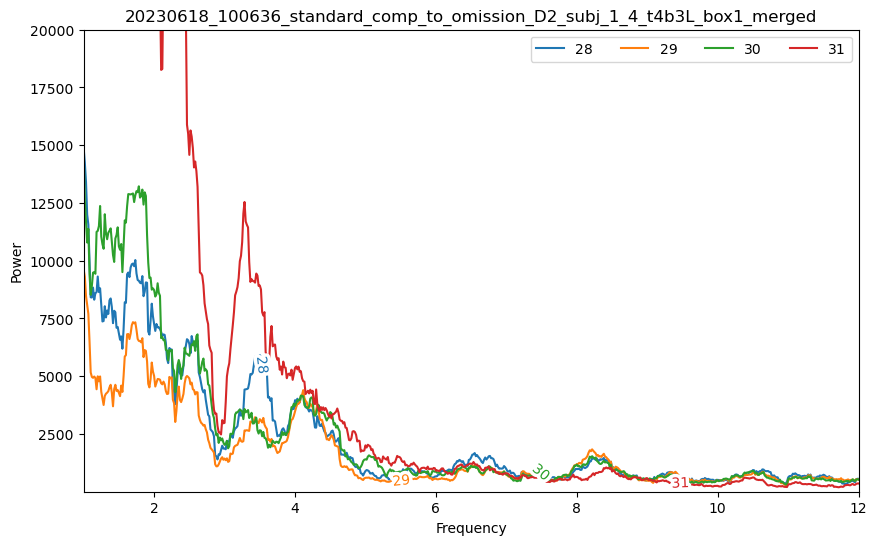

In [31]:
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    print(preprocessed_lfp_path)
    recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
    recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
    parent_output_directory = os.path.dirname(preprocessed_lfp_path)


    
    
       ### Reading in the recording
    trodes_recording = se.read_spikegadgets("/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec/20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec", stream_id="trodes")

    ### Preprocessing the recording
    preprocessing_step_dict = defaultdict(dict)
    preprocessing_step_dict["recording_raw"] = trodes_recording

    recording_intermediate = copy.copy(trodes_recording)
    # Bandpass Filtering, keeping all the points that are within a certain frequency range
    recording_bandpass = spikeinterface.preprocessing.bandpass_filter(recording_intermediate, freq_min=0.5, freq_max=300)
    recording_intermediate = spikeinterface.preprocessing.bandpass_filter(recording_intermediate, freq_min=0.5, freq_max=300)
    preprocessing_step_dict["recording_bandpass"] = recording_bandpass
    print(recording_bandpass)
    
    # Notch Filtering, keeping all the points that are within a certain frequency range
    recording_notch = spikeinterface.preprocessing.notch_filter(recording_intermediate, freq=60)
    recording_intermediate = spikeinterface.preprocessing.notch_filter(recording_intermediate, freq=60)
    preprocessing_step_dict["recording_notch"] = recording_notch
    print(recording_bandpass)

    # We are not going to run the resampling step because it causes issues with saving to file
    # Resampling
    recording_resample = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency)
    preprocessing_step_dict["recording_resample"] = recording_resample
    print(recording_resample)

    # Getting the traces
    
    traces = recording_intermediate.get_traces(start_frame=1100*1000, end_frame=1160*1000)
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    
    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    for num in range(8):
        channels = [int(num) for num in recording_intermediate.channel_ids[num*4: num*4+4]]
        
    
    
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.plot(c.frequencies, c.power().squeeze()[:,channels], label=channels)
        ax.set_xlim(1,12)
        ax.legend(ncol=4)
        ax.set_ylim(1,20000)
        labelLines(ax.get_lines(), zorder=2.5)
        plt.title(recording_basename)
        os.makedirs('./proc/{}'.format(recording_basename), exist_ok=True)
        plt.savefig('./proc/{}/{}_ch_{}.png'.format(recording_basename, recording_basename, "-".join([str(ch) for ch in channels])))
        plt.show()


./proc/20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged/lfp_preprocessing


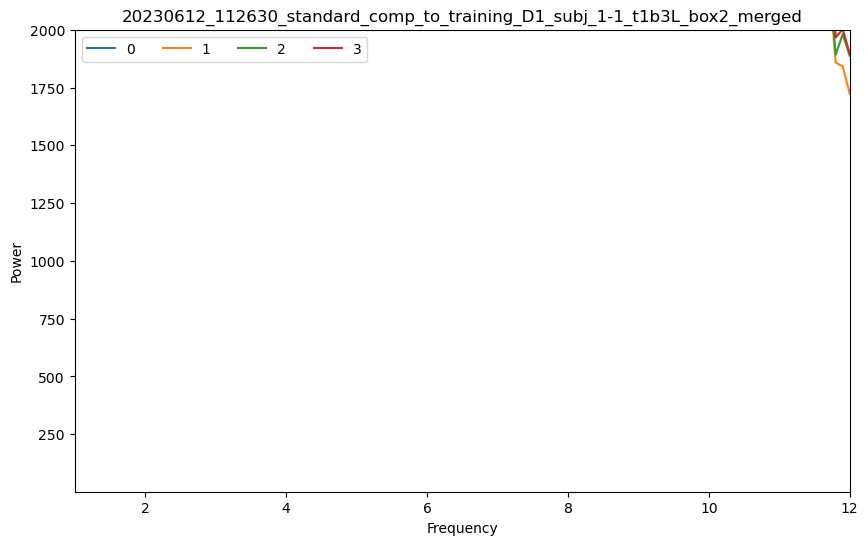

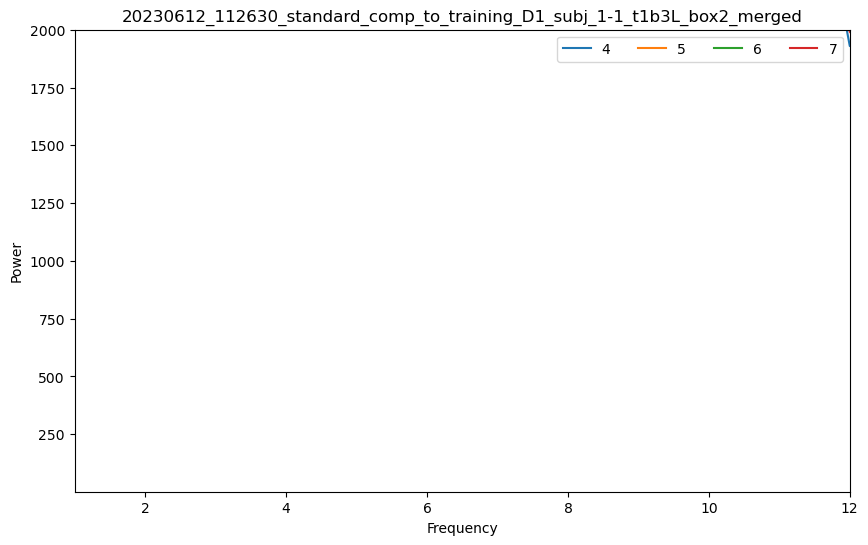

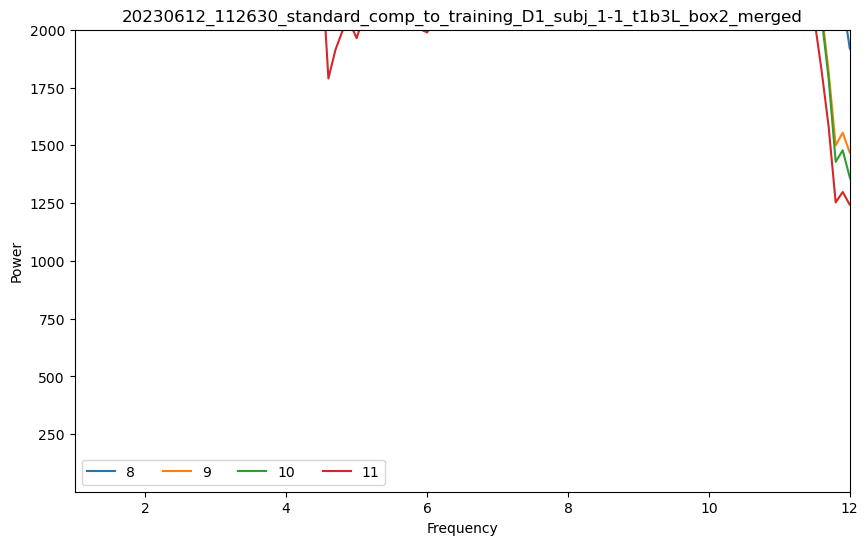

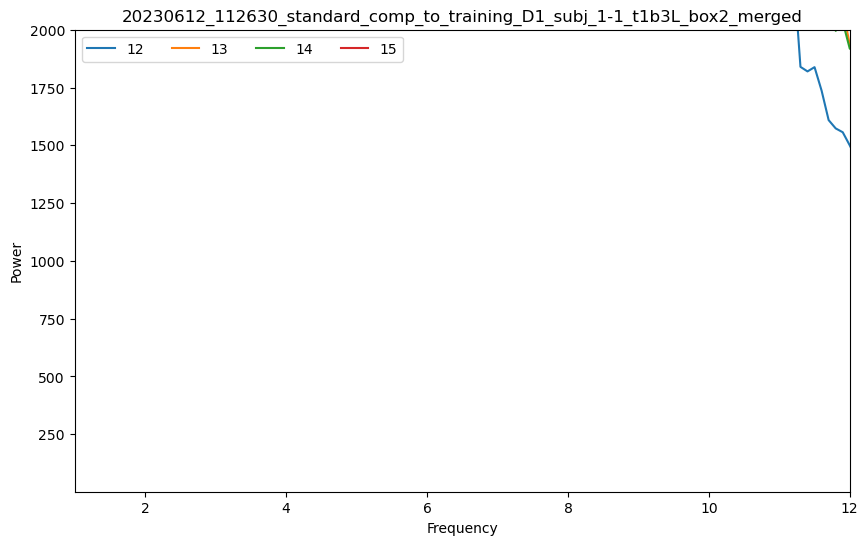

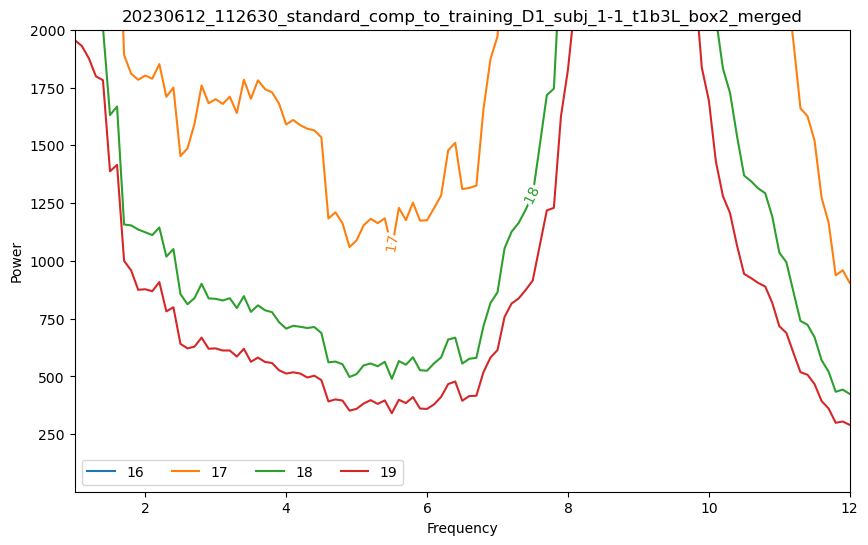

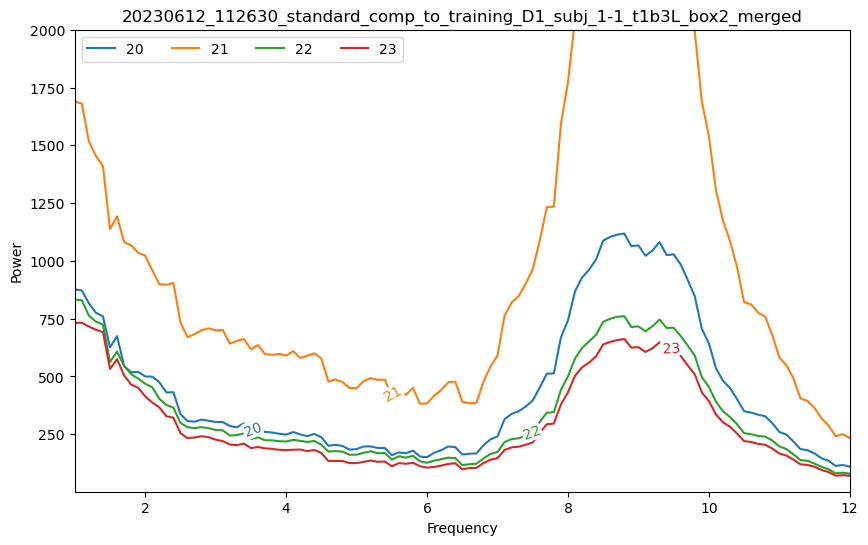

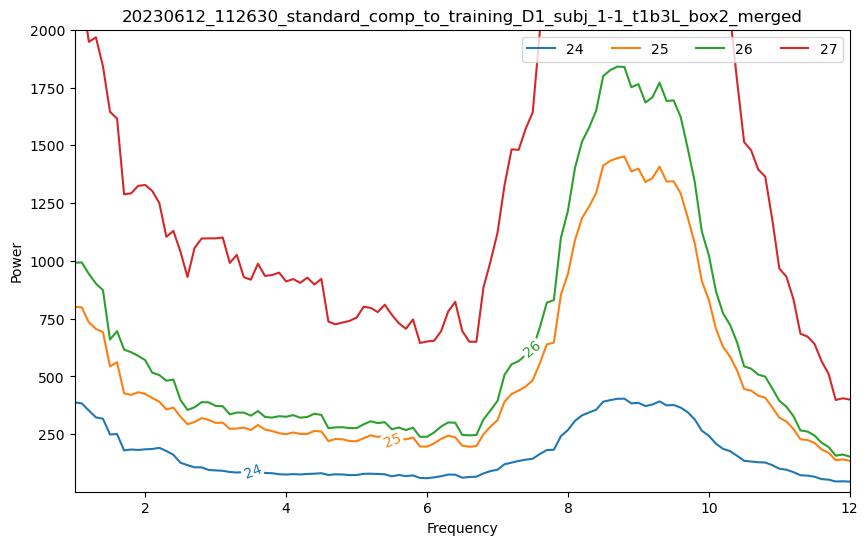

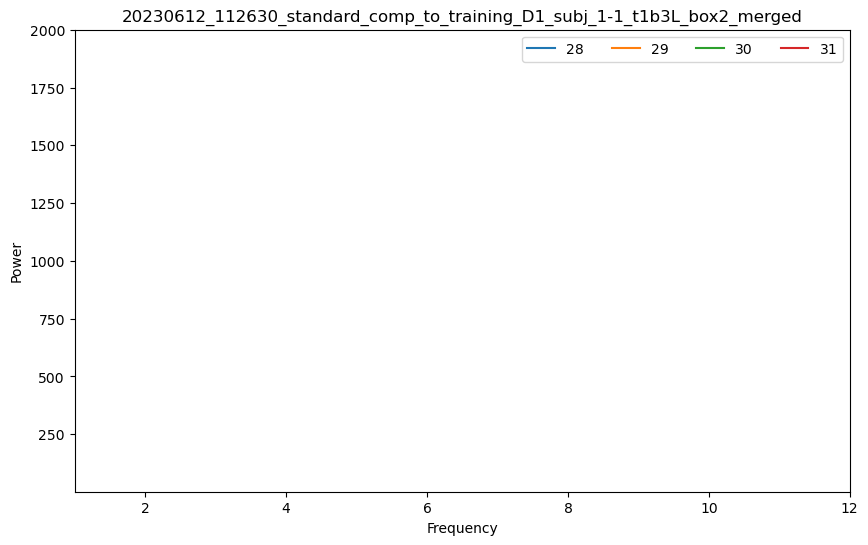

./proc/20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged/lfp_preprocessing


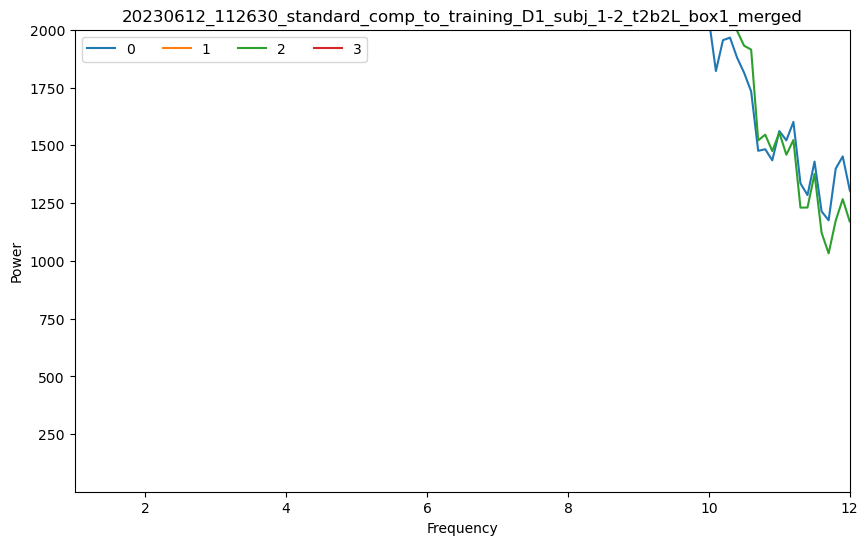

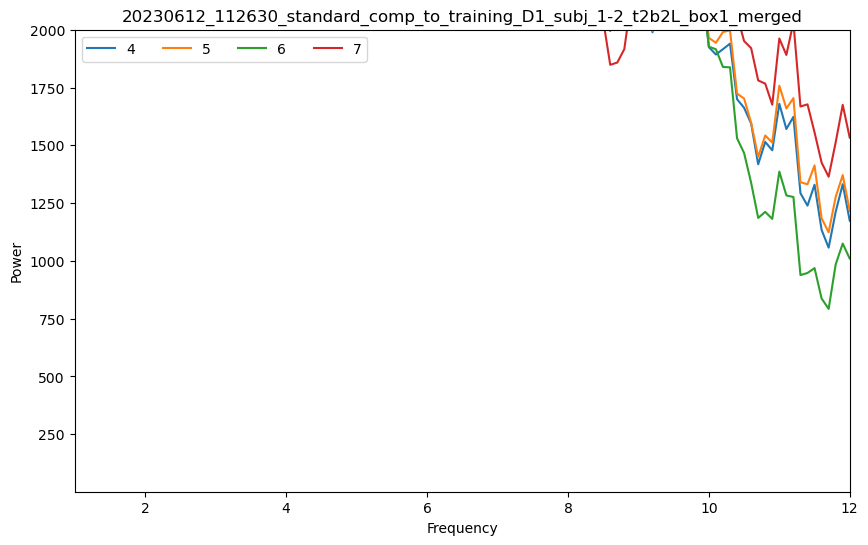

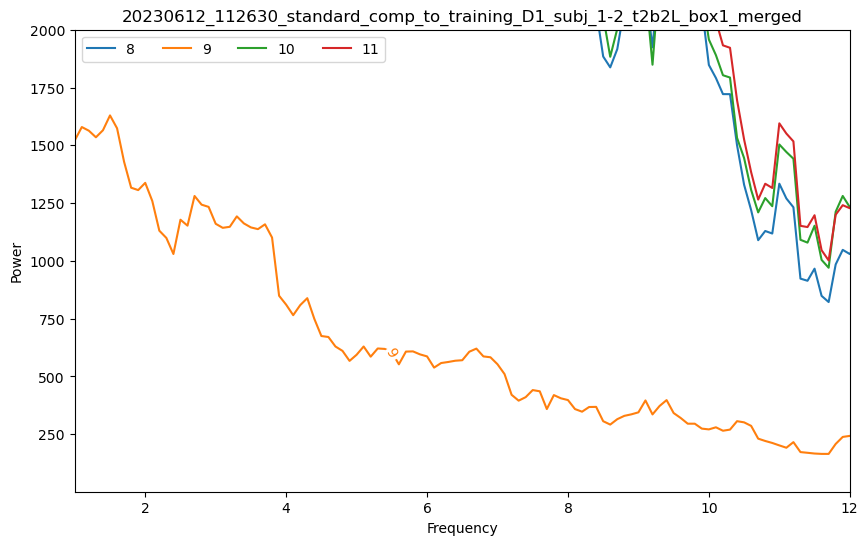

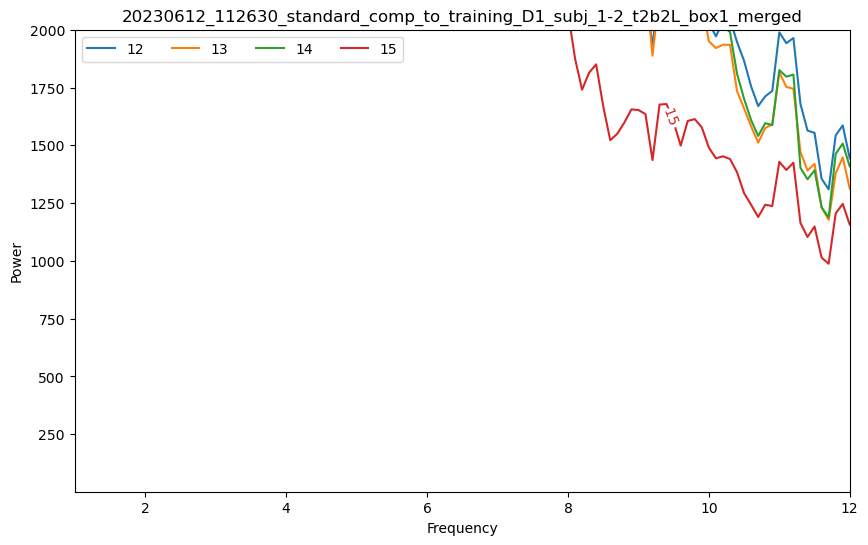

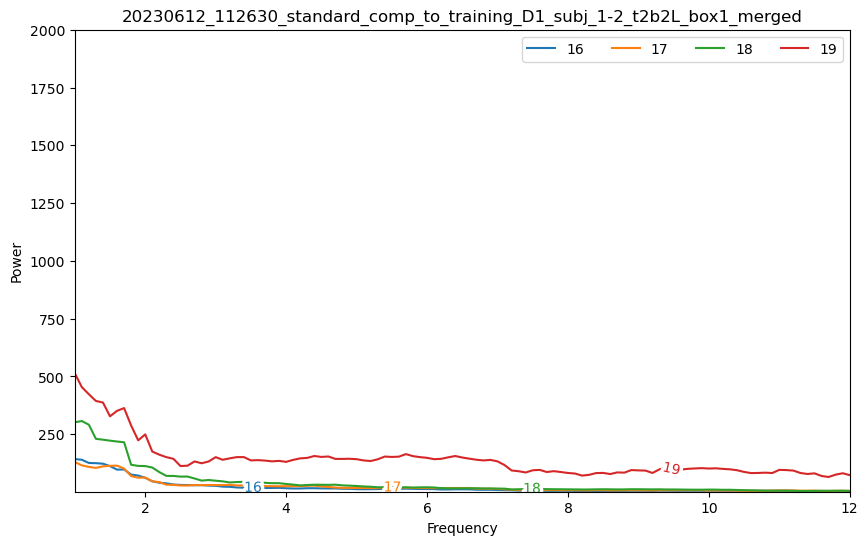

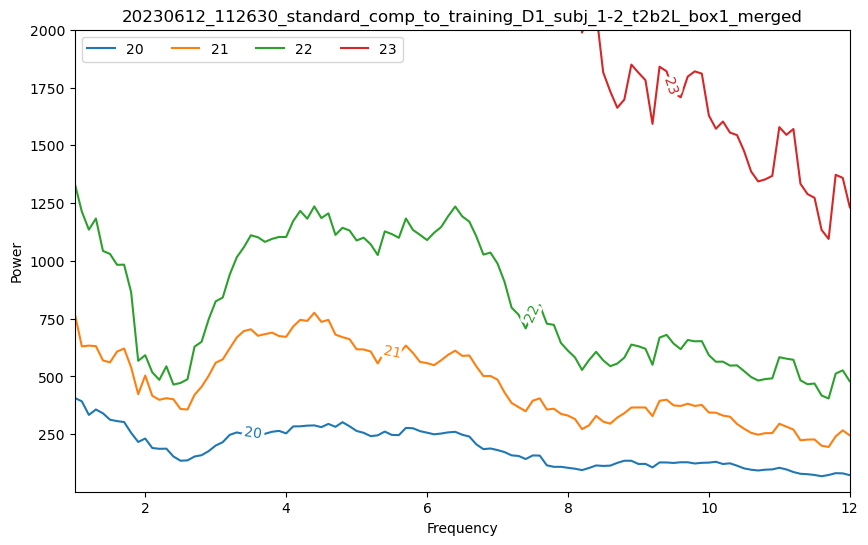

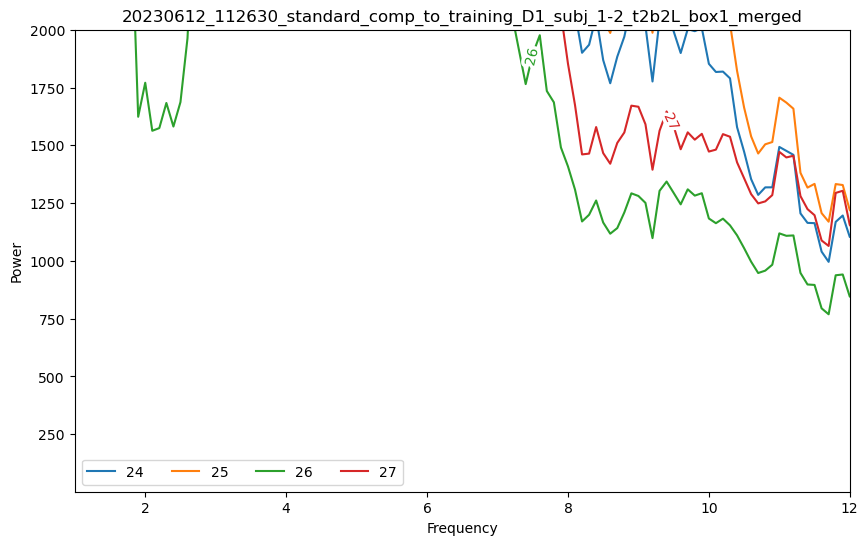

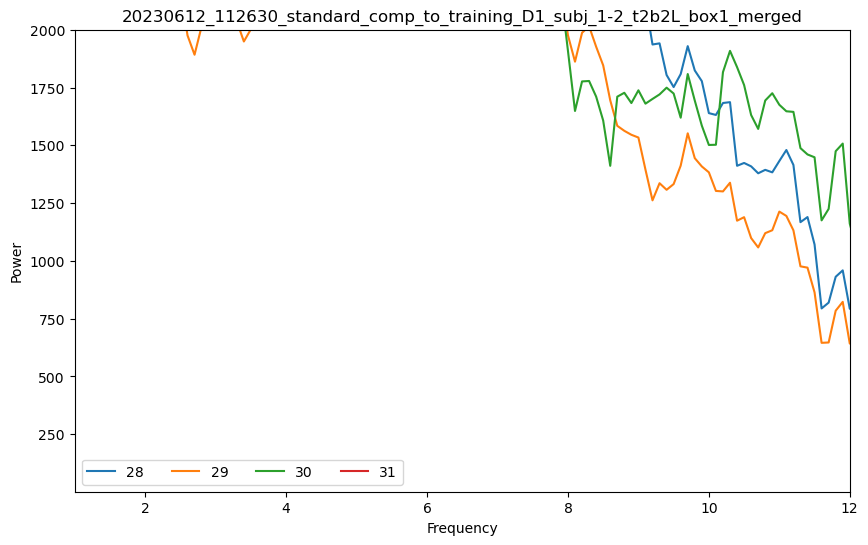

./proc/20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged/lfp_preprocessing


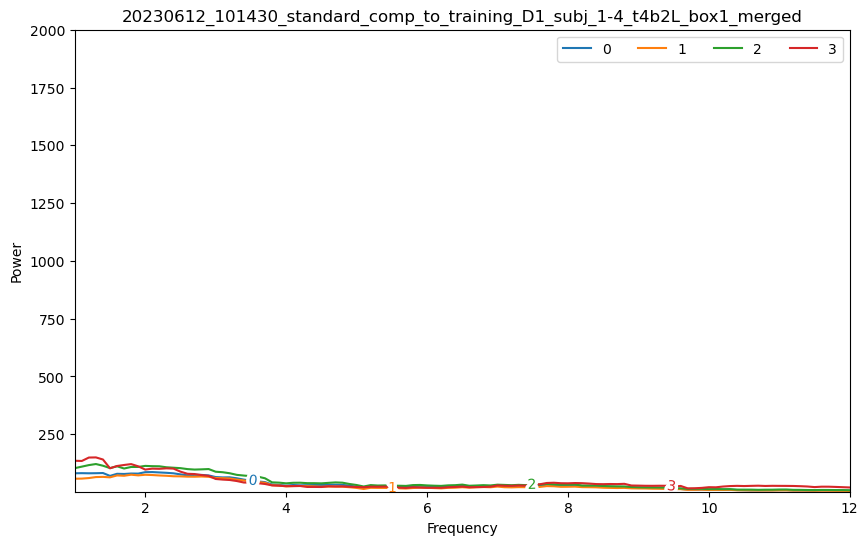

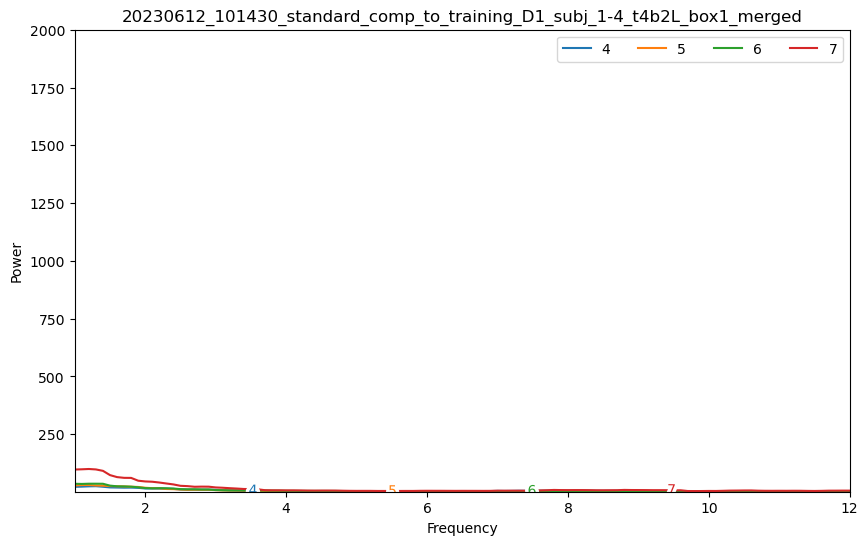

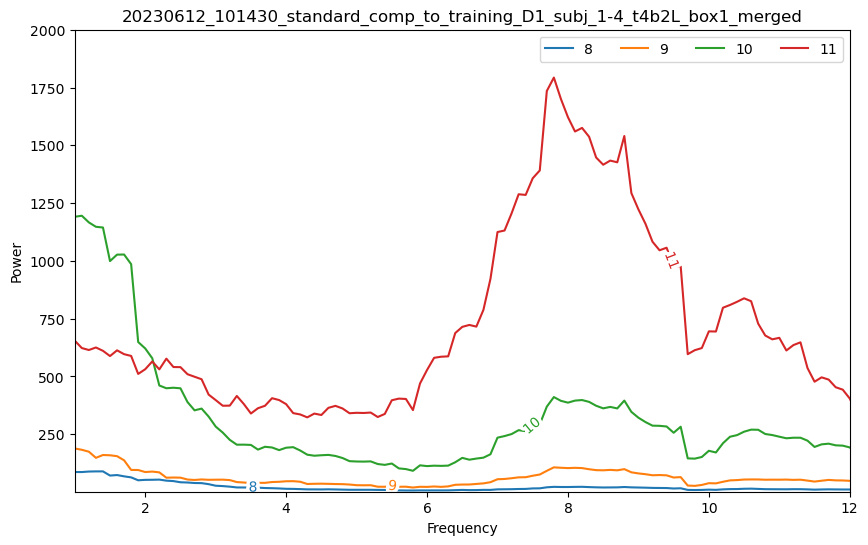

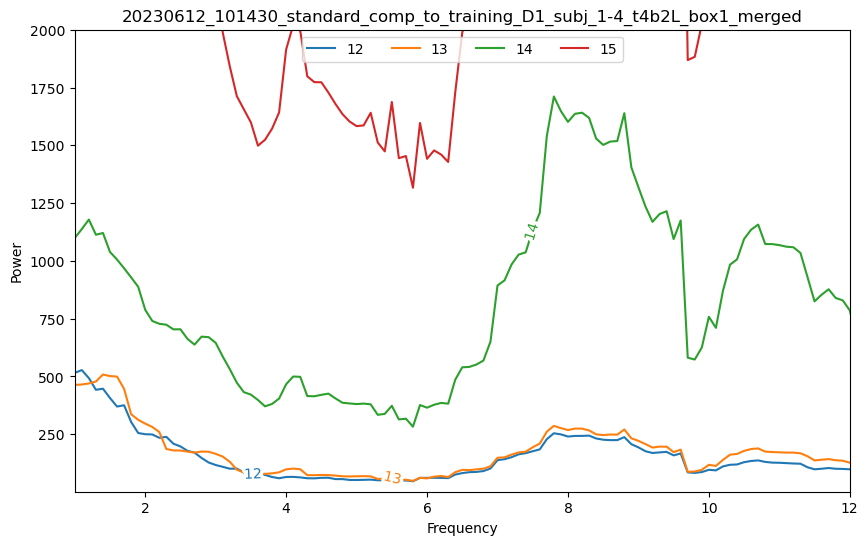

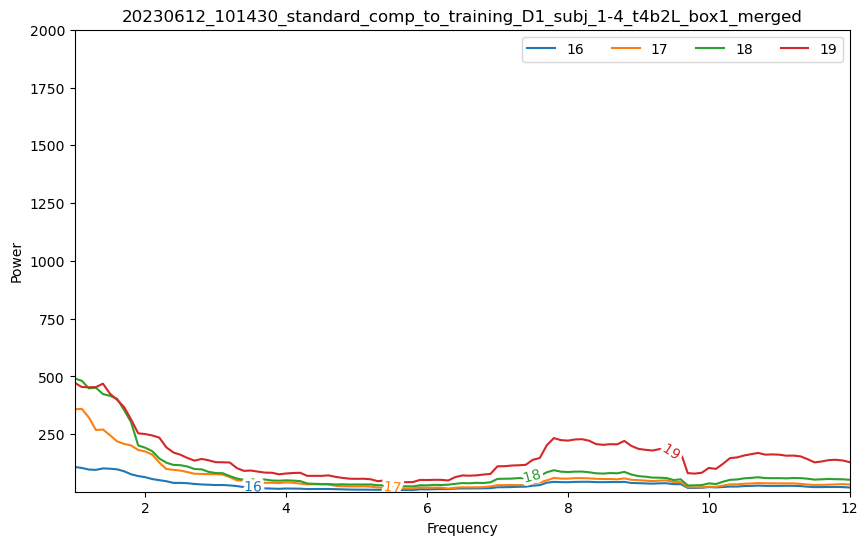

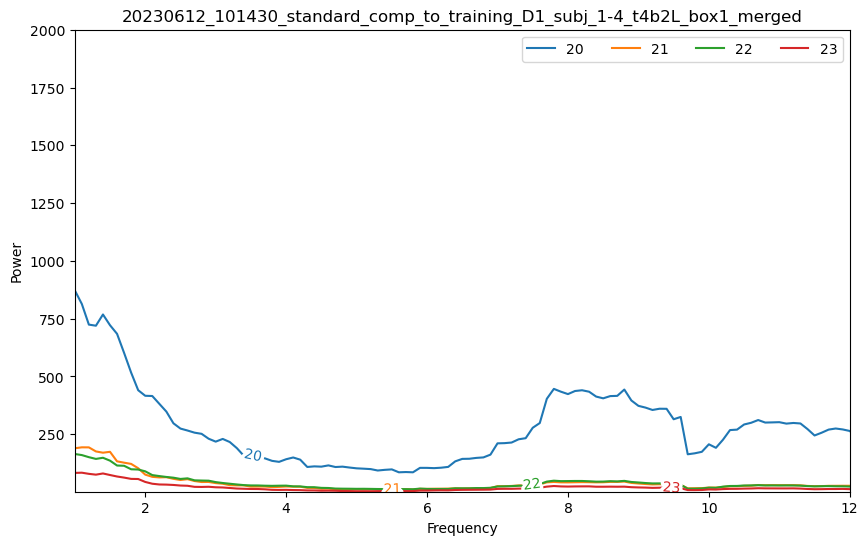

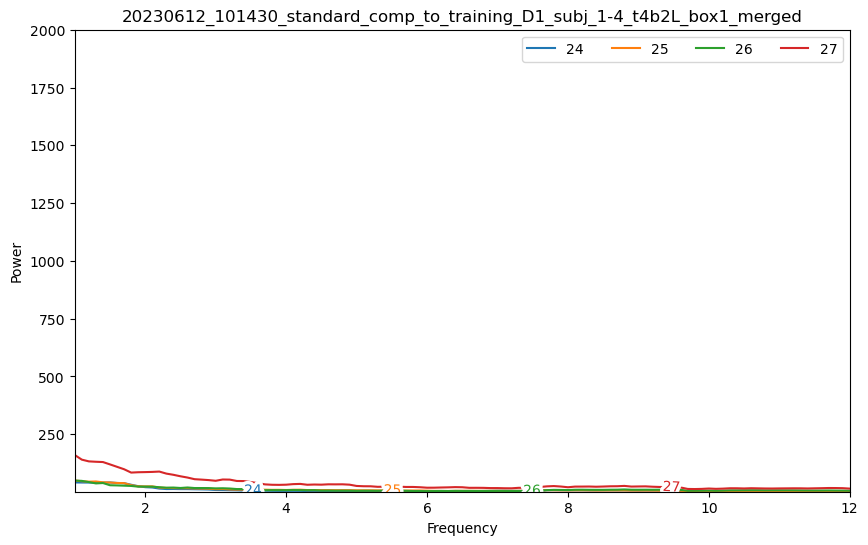

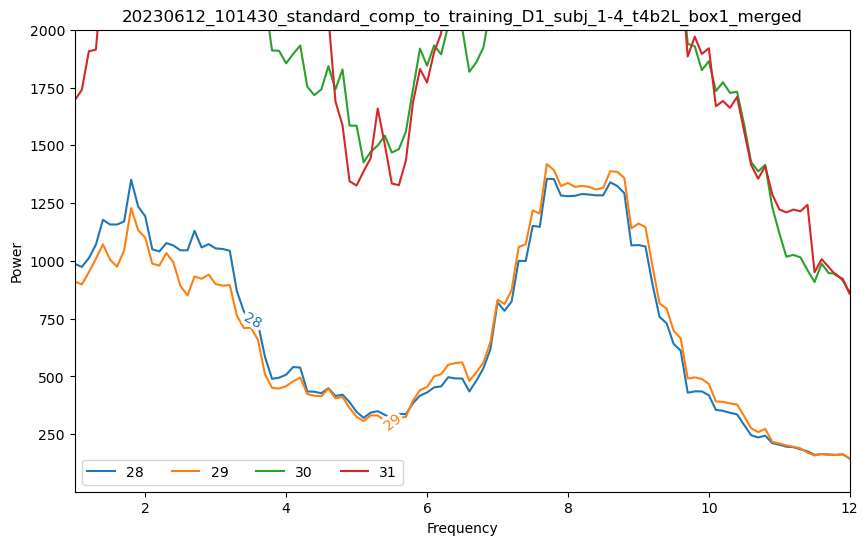

./proc/20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged/lfp_preprocessing


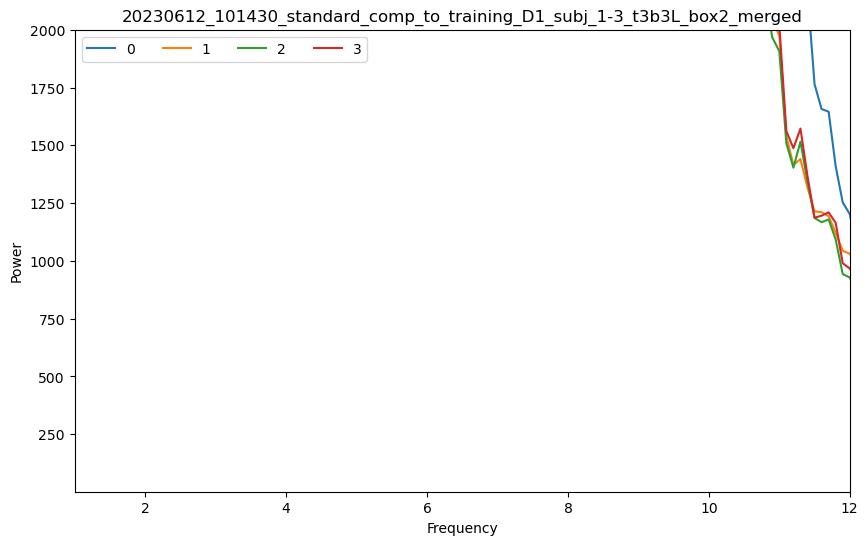

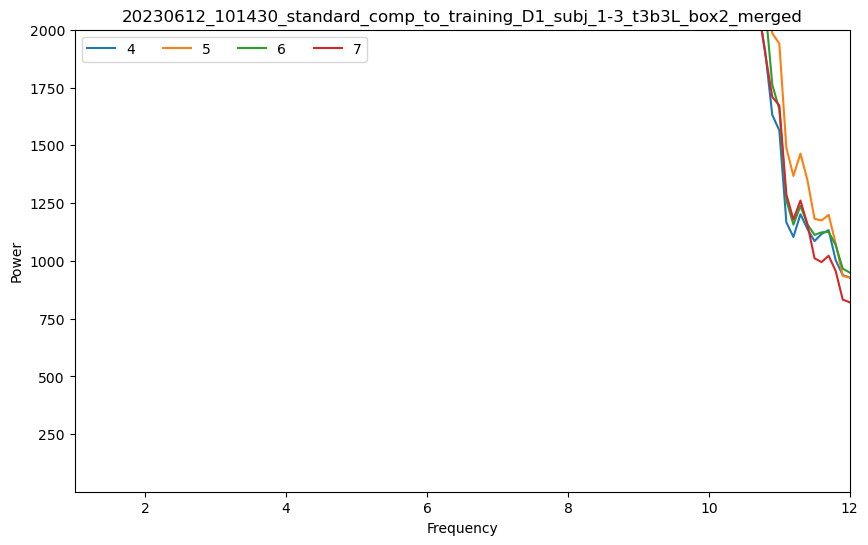

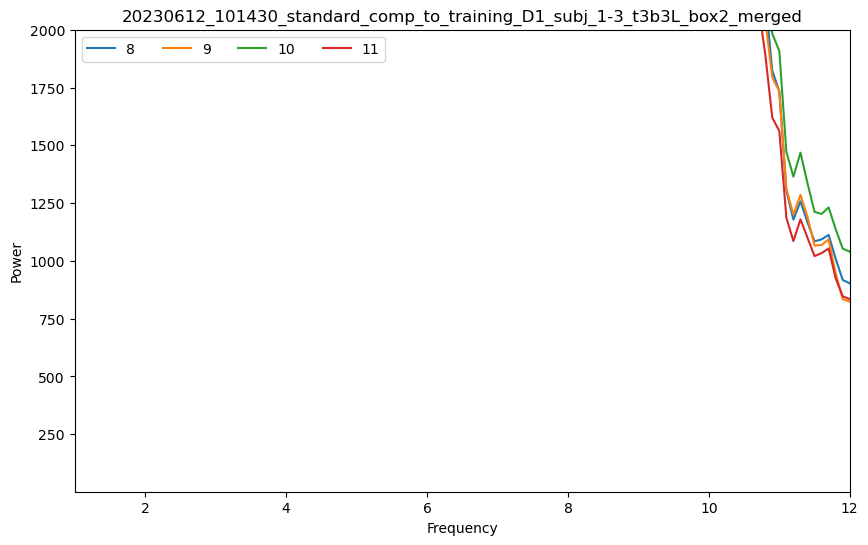

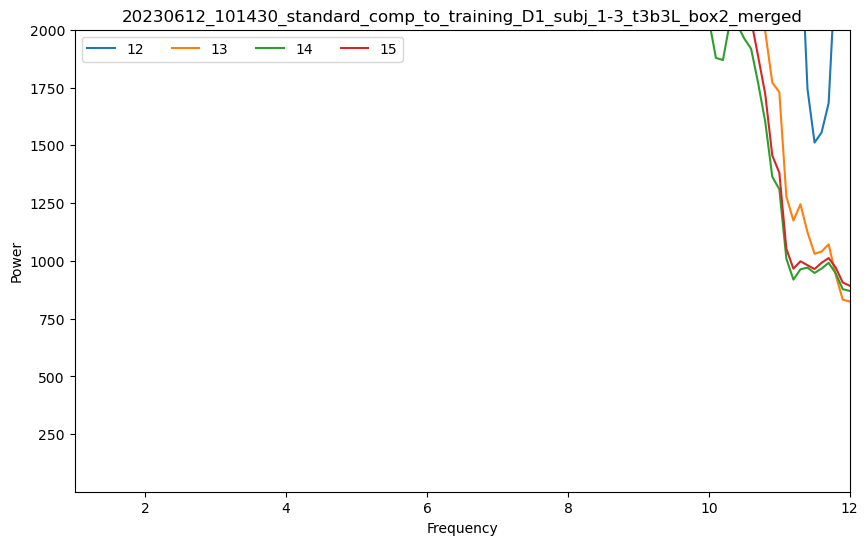

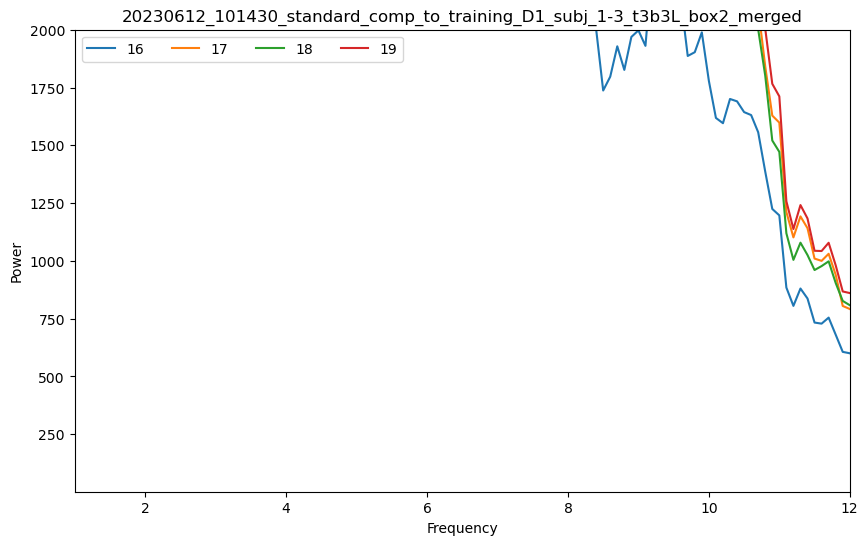

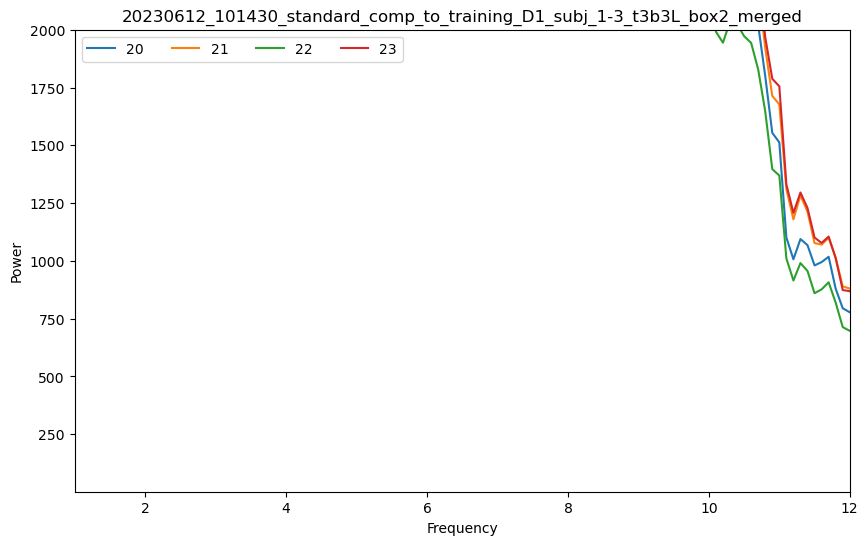

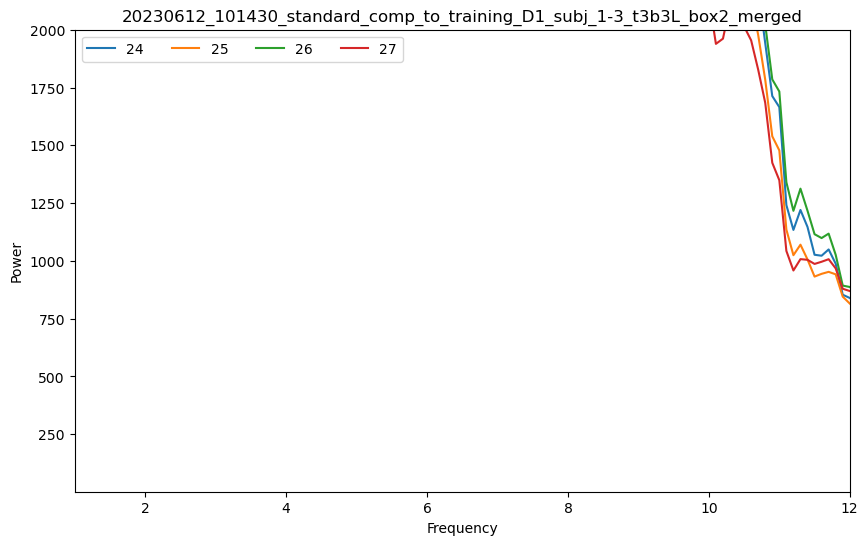

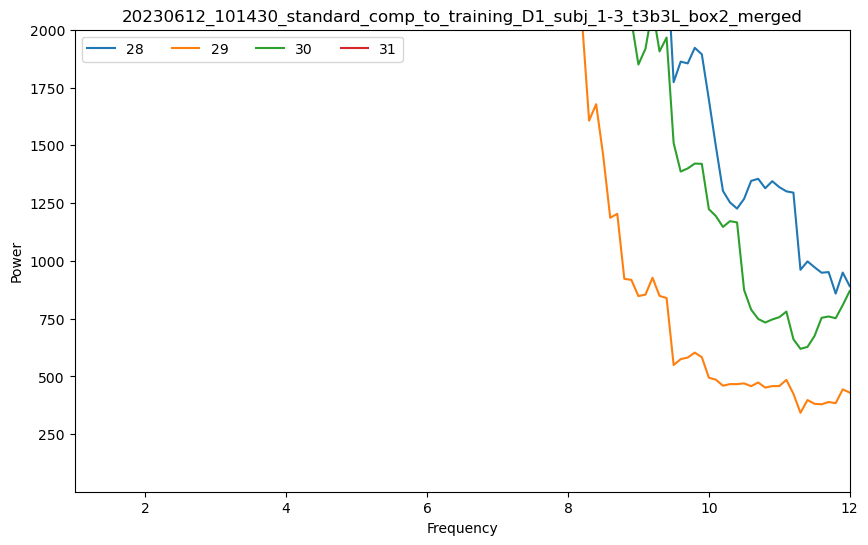

In [26]:
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    print(preprocessed_lfp_path)
    recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
    recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
    parent_output_directory = os.path.dirname(preprocessed_lfp_path)

    
    # Resampling
    recording_intermediate = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency) 
#     sw.plot_timeseries(recording_intermediate, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)

    # Getting the traces
    
    traces = recording_intermediate.get_traces(start_frame=1000*1000, end_frame=1010*1000)
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    
    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    for num in range(8):
        channels = [int(num) for num in recording_intermediate.channel_ids[num*4: num*4+4]]
        
    
    
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.plot(c.frequencies, c.power().squeeze()[:,channels], label=channels)
        ax.set_xlim(1,12)
        ax.set_ylim(1,2000)

        ax.legend(ncol=4)
        labelLines(ax.get_lines(), zorder=2.5)
        plt.title(recording_basename)
        plt.show()


### Get all the traces

In [27]:
raise ValueError()

ValueError: 

In [ ]:
recording_root_to_everything = defaultdict(dict)

In [ ]:
resampled_frequency = 1000

In [ ]:
np_issue_files = []
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    try:
        print(preprocessed_lfp_path)
        recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
        recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
        parent_output_directory = os.path.dirname(preprocessed_lfp_path)

        # Resampling
        recording_intermediate = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency) 

        # Getting the traces
        
        traces = recording_intermediate.get_traces(start_frame=0, end_frame=recording_intermediate.get_num_samples()-1)
        # Saving the trace to a Numpy file
        traces_filename = "{}.traces.npy".format(recording_basename)
        np.save(file=os.path.join(parent_output_directory, traces_filename), arr=traces)
    except:
        np_issue_files.append(preprocessed_lfp_path)